Here we visualize filters and outputs using the network architecture proposed by Krizhevsky et al. for ImageNet and implemented in `caffe`.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [2]:
caffe.set_mode_cpu()
net = caffe.Net('rcnn_model/deploy.prototxt',
                'rcnn_model/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

net = caffe.Net('rcnn_model/deploy_nn_background.prototxt',
                'rcnn_model/caffenet_train_background_iter_10000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Classify the image by reshaping the net for the single input then doing the forward pass.

In [3]:
net.blobs['data'].reshape(1,3,227,227)
pict = caffe.io.load_image('13.jpg')
mean_pict = pict.mean(-1)
pict[:,:,0], pict[:,:,1], pict[:,:,2] = mean_pict, mean_pict, mean_pict
net.blobs['data'].data[...] = transformer.preprocess('data', pict)
out = net.forward()
print out.keys()
#print("Predicted class is #{}.".format(out['fc-rcnn'].argmax()))
print("Predicted class is #{}.".format(out['output'].argmax()))

['output']
Predicted class is #0.


The layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [4]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (1, 96, 55, 55)),
 ('pool1', (1, 96, 27, 27)),
 ('norm1', (1, 96, 27, 27)),
 ('conv2', (1, 256, 27, 27)),
 ('pool2', (1, 256, 13, 13)),
 ('norm2', (1, 256, 13, 13)),
 ('conv3', (1, 384, 13, 13)),
 ('conv4', (1, 384, 13, 13)),
 ('conv5', (1, 256, 13, 13)),
 ('pool5', (1, 256, 6, 6)),
 ('fc6', (1, 4096)),
 ('fc7', (1, 4096)),
 ('fc8_VOC', (1, 6)),
 ('output', (1, 6))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [5]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8_VOC', (6, 4096))]

Helper functions for visualization

In [6]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

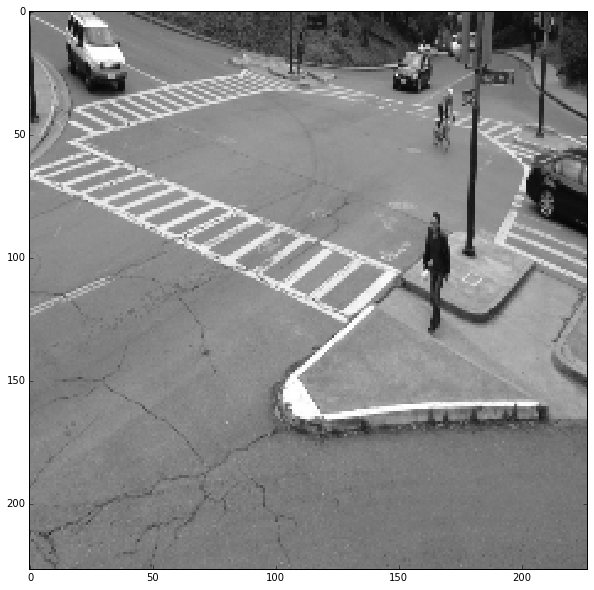

In [7]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

The first layer filters, `conv1`

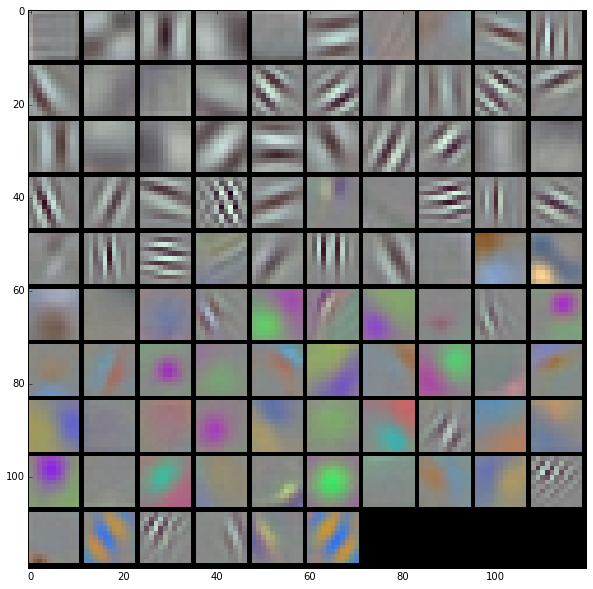

In [8]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

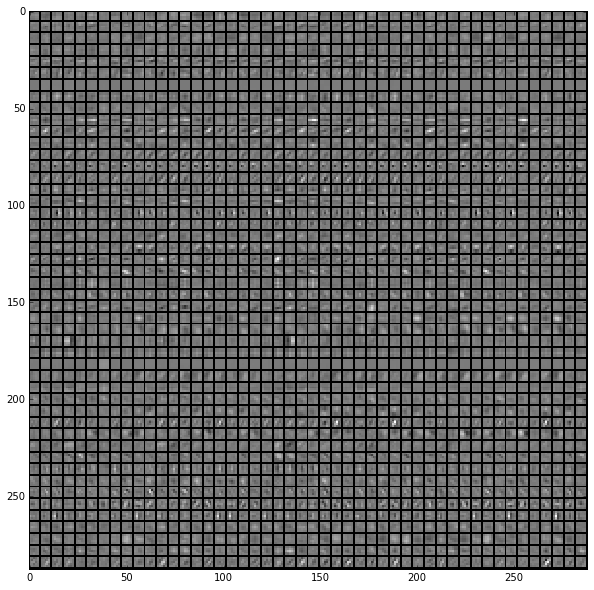

In [9]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

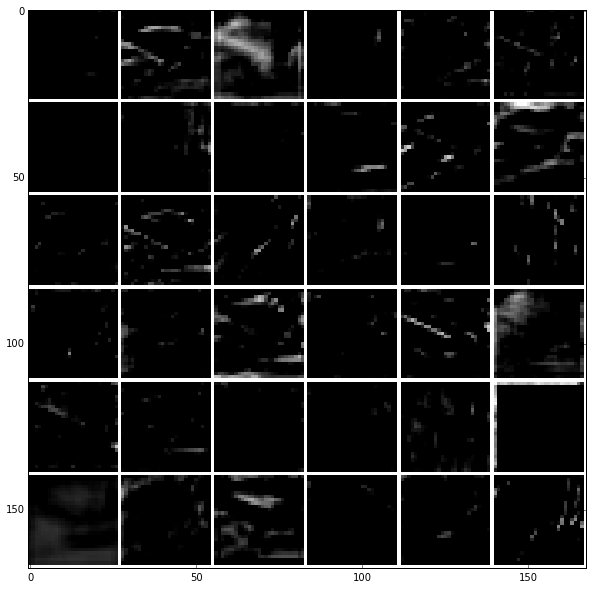

In [10]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

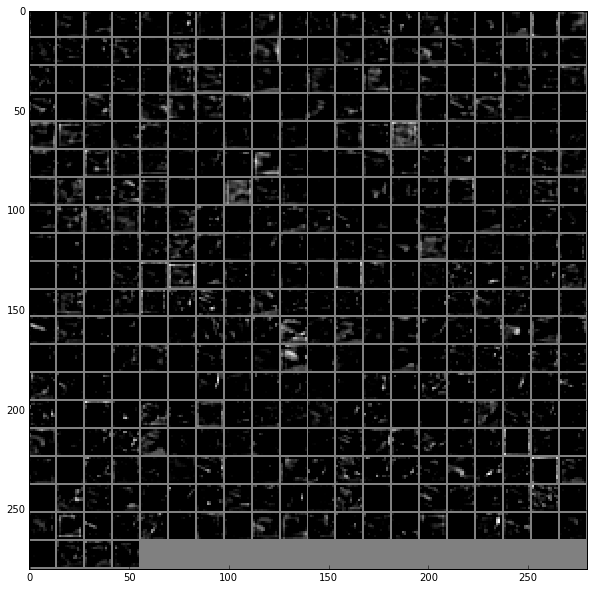

In [11]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

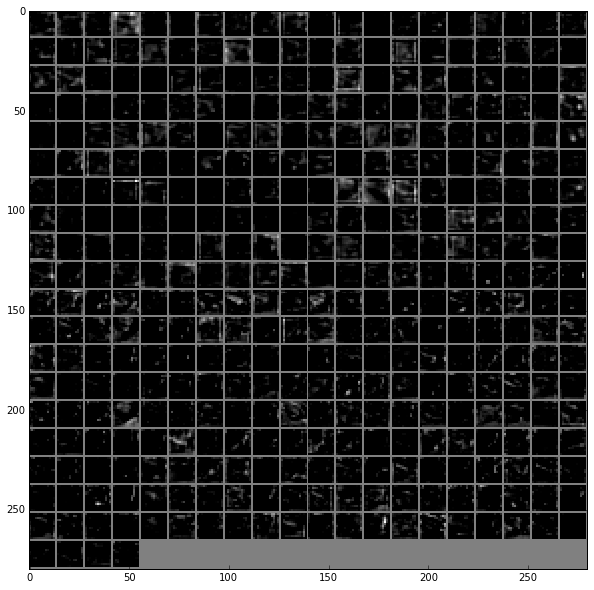

In [12]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

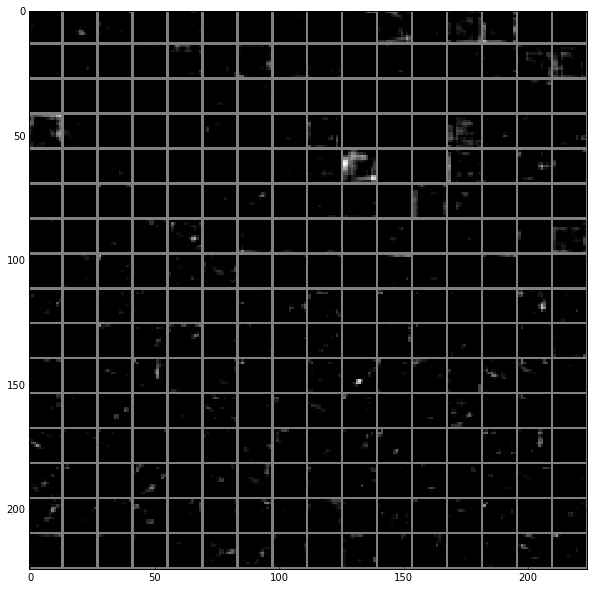

In [13]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

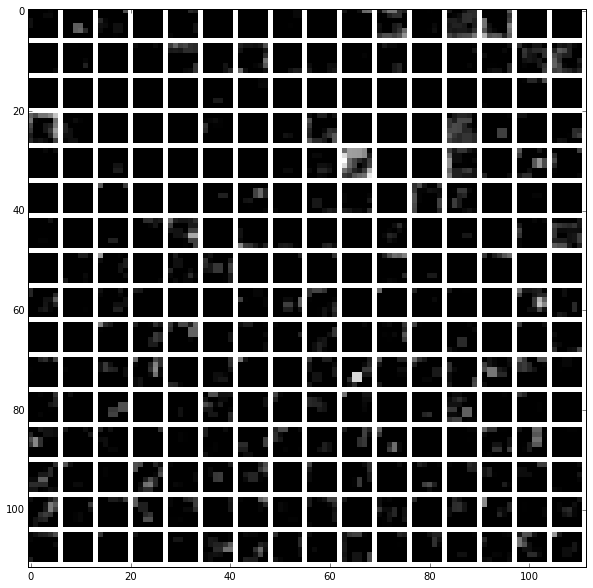

In [14]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

In [15]:
layer_names = net.blobs.keys()
print layer_names
layers_of_interest = ['norm1', 'norm2', 'conv3', 'conv4', 'pool5']
for layer_name in layers_of_interest:
    print net.blobs[layer_name].data.shape

['data', 'conv1', 'pool1', 'norm1', 'conv2', 'pool2', 'norm2', 'conv3', 'conv4', 'conv5', 'pool5', 'fc6', 'fc7', 'fc8_VOC', 'output']
(1, 96, 27, 27)
(1, 256, 13, 13)
(1, 384, 13, 13)
(1, 384, 13, 13)
(1, 256, 6, 6)


In [16]:
from scipy.interpolate import Rbf

def stack_features(net, input_name, target_name):
    target_layer  = net.blobs[target_name]
    n_target_feats = target_layer.data.shape[1]
    #
    desired_shape = net.blobs[input_name].data.shape[-2:]
    current_shape = net.blobs[target_name].data.shape[-2:]
    result = np.zeros((n_target_feats, desired_shape[0], desired_shape[1]))
    #
    t_h = current_shape[0]
    t_w = current_shape[1]
    x, y = np.mgrid[-1:1:1j*t_h, -1:1:1j*t_w]
    #
    new_t_h = desired_shape[0]
    new_t_w = desired_shape[1]
    x_new, y_new = np.mgrid[-1:1:1j*new_t_h,-1:1:1j*new_t_w]
    #
    for target_feat in xrange(n_target_feats):
        z = target_layer.data[0,target_feat,:,:]
        rbf = Rbf(x, y, z, epsilon=0.5)
        result[target_feat,:,:] = rbf(x_new, y_new)
    return result

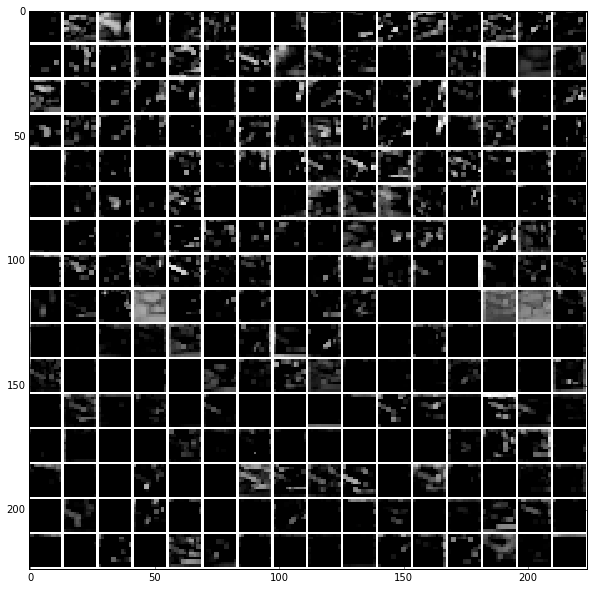

In [ ]:
feat = net.blobs['norm2'].data[0]
vis_square(feat, padval=1)

In [ ]:
input_name    = 'data'
layers_of_interest = ['norm1', 'norm2', 'conv3', 'conv4', 'pool5']

stacked_feats = [stack_features(net, input_name, target_name) for target_name in layers_of_interest]

stacked_feats = np.vstack(stacked_feats)

print stacked_feats.shape

vis_square(stacked_feats, padval=1)

In [ ]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

import scipy.sparse as sparse
import time

print stacked_feats.shape

stacked_feats_t = np.transpose(stacked_feats, (1, 2, 0))

print stacked_feats.shape

h = stacked_feats_t.shape[0]
w = stacked_feats_t.shape[1]
d = stacked_feats_t.shape[2]

flat_feats = np.reshape(stacked_feats_t, (h * w, d))

# Convert the image into a graph
graph = image.grid_to_graph(n_x = h, n_y = w)

non_zero_indices = zip(*graph.nonzero())

for idx, (i,j) in enumerate(non_zero_indices):
    graph.data[idx] = np.mean((flat_feats[i] - flat_feats[j]) ** 2)

beta = 1e-2
eps = 1e-3
graph.data = np.exp(- beta * graph.data / flat_feats.var()) + eps

N_REGIONS = 8

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels)
    t1 = time.time()
    labels = labels.reshape((h, w))
    plt.figure(figsize=(5, 5))
    plt.imshow(labels, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))
    

In [ ]:
from sklearn.feature_extraction import image
from sklearn.cluster import AgglomerativeClustering

stacked_feats_t = np.transpose(stacked_feats, (1, 2, 0))

h = stacked_feats_t.shape[0]
w = stacked_feats_t.shape[1]
d = stacked_feats_t.shape[2]

flat_feats = np.reshape(stacked_feats_t, (h * w, d))

# Convert the image into a graph
graph = image.grid_to_graph(n_x = h, n_y = w)

N_REGIONS = 50
agg_clustering = AgglomerativeClustering(n_clusters=N_REGIONS,
                                         linkage = 'ward',
                                         connectivity = graph).fit(flat_feats)



labels = agg_clustering.labels_.reshape((h, w))
plt.figure(figsize=(5, 5))
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
for l in range(N_REGIONS):
    plt.contour(labels == l, contours=1,
                colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
plt.xticks(())
plt.yticks(())
plt.title('Hierarchical clustering: %.2fs' % (t1 - t0))